In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import glob
import librosa
import numpy as np

# Ruta a tu carpeta en Drive
path = "/content/drive/MyDrive/Audios/segmentosWaveNet/*.wav"
files = glob.glob(path)

sr = 16000  # frecuencia objetivo
dataset = []

print("Archivos encontrados:", len(files))

for f in files:
    try:
        y, _ = librosa.load(f, sr=sr, mono=True)
        dataset.append(y)
    except Exception as e:
        print("No se pudo leer:", f, "| Error:", e)

# Concatenar todo en un solo array largo
if len(dataset) > 0:
    audio_data = np.concatenate(dataset)
    print("Dataset cargado")
    print("Duración total (segundos):", round(len(audio_data)/sr, 2))
else:
    print("Ningún archivo cargado")


Archivos encontrados: 108
Dataset cargado
Duración total (segundos): 540.0


In [ ]:
# Mu-law encoding y decoding
def mu_law_encode(audio, mu=255):
    audio = np.clip(audio, -1, 1)
    encoded = np.sign(audio) * np.log1p(mu * np.abs(audio)) / np.log1p(mu)
    return ((encoded + 1) / 2 * mu).astype(np.int32)

def mu_law_decode(encoded, mu=255):
    norm = encoded.astype(np.float32) / mu * 2 - 1
    return np.sign(norm) * (1 / mu) * ((1 + mu) ** np.abs(norm) - 1)

print("Funciones mu-law definidas")


Funciones mu-law definidas


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Función para construir Mini-WaveNet
def build_wavenet_model(input_length, quantization_channels=256):
    inputs = layers.Input(shape=(input_length,), dtype='int32')

    # Embedding para convertir enteros a vectores
    x = layers.Embedding(input_dim=quantization_channels, output_dim=64)(inputs)

    # Causal 1D convolutions
    skips = []
    for i, dilation_rate in enumerate([1, 2, 4, 8, 16]):
        conv_filter = layers.Conv1D(64, kernel_size=2,
                                    padding='causal', dilation_rate=dilation_rate,
                                    activation='tanh')(x)
        conv_gate = layers.Conv1D(64, kernel_size=2,
                                  padding='causal', dilation_rate=dilation_rate,
                                  activation='sigmoid')(x)
        z = layers.Multiply()([conv_filter, conv_gate])

        skip = layers.Conv1D(64, kernel_size=1)(z)
        skips.append(skip)
        x = layers.Add()([x, skip])  # residual connection

    out = layers.Add()(skips)
    out = layers.Activation('relu')(out)
    out = layers.Conv1D(128, kernel_size=1, activation='relu')(out)
    out = layers.Conv1D(quantization_channels, kernel_size=1, activation='softmax')(out)

    # Cortamos solo el último tiempo
    out = layers.Lambda(lambda x: x[:, -1, :])(out)

    return tf.keras.Model(inputs, out)

# Parámetros de entrada
SEQ_LEN = 512  # longitud de secuencia (pasos de audio)
model = build_wavenet_model(input_length=SEQ_LEN)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 512, 64)   │     16,384 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 512, 64)   │      8,256 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 512, 64)   │      8,256 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 512, 64)   │          0 │ conv1d[0][0],     │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 512, 64)   │      4,160 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512, 64)   │          0 │ embedding[0][0],  │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 512, 64)   │      8,256 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 512, 64)   │      8,256 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 512, 64)   │          0 │ conv1d_3[0][0],   │
│ (Multiply)          │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 512, 64)   │      4,160 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 512, 64)   │          0 │ add[0][0],        │
│                     │                   │            │ conv1d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 512, 64)   │      8,256 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 512, 64)   │      8,256 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 512, 64)   │          0 │ conv1d_6[0][0],   │
│ (Multiply)          │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 512, 64)   │      4,160 │ multiply_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 512, 64)   │          0 │ add_1[0][0],      │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 512, 64)   │      8,256 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 512, 64)   │      8,256 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 512, 64)   │          0 │ conv1d_9[0][0],   │
│ (Multiply)          │                   │            │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 161,088 (629.25 KB)

 Trainable params: 161,088 (629.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Crear muestras (X, y) con muestreo aleatorio limitado
import random

SEQ_LEN = 512
NUM_SAMPLES = 50000

encoded_audio = mu_law_encode(audio_data)

X = []
y = []

max_start = len(encoded_audio) - SEQ_LEN - 1
starts = random.sample(range(max_start), NUM_SAMPLES)

for i in starts:
    X.append(encoded_audio[i:i+SEQ_LEN])
    y.append(encoded_audio[i+SEQ_LEN])

X = np.array(X, dtype=np.int32)
y = np.array(y, dtype=np.int32)

print("Batches creados")
print("X shape:", X.shape)
print("y shape:", y.shape)


Batches creados
X shape: (50000, 512)
y shape: (50000,)


In [ ]:
# Entrenamiento del modelo WaveNet reducido
EPOCHS = 10
BATCH_SIZE = 64

history = model.fit(X, y,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)

print("Entrenamiento finalizado")


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 880s 1s/step - loss: 2.7367
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 879s 1s/step - loss: 1.0206
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 923s 1s/step - loss: 0.8627
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 914s 1s/step - loss: 0.7957
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 899s 1s/step - loss: 0.7451
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 848s 1s/step - loss: 0.7033
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 862s 1s/step - loss: 0.6751
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 867s 1s/step - loss: 0.6518
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 847s 1s/step - loss: 0.6326
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 860s 1s/step - loss: 0.6108
Entrenamiento finalizado


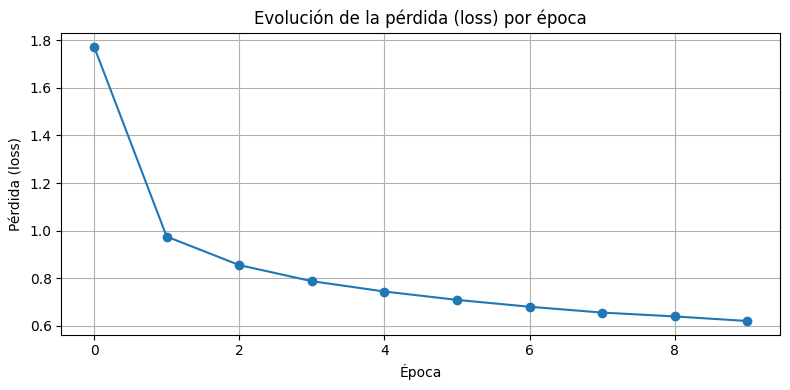

In [ ]:
import matplotlib.pyplot as plt

# Gráfica de pérdida por época
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], marker='o')
plt.title("Evolución de la pérdida (loss) por época")
plt.xlabel("Época")
plt.ylabel("Pérdida (loss)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import os
import soundfile as sf
from tqdm import tqdm
from IPython.display import Audio, display

# Función para generar 1 audio completo
def generate_audio(model, seed, total_samples=80000, seq_len=512):
    generated = list(seed)
    for _ in tqdm(range(total_samples), desc="Generando audio"):
        x_in = np.array(generated[-seq_len:]).reshape(1, -1)
        pred = model.predict(x_in, verbose=0)
        next_sample = np.argmax(pred[0])
        generated.append(next_sample)
    return np.array(generated)

# Función para generar múltiples audios
def generar_multiples_audios(model, n=3, dur_sec=5, sr=16000, carpeta='audios_generados'):
    os.makedirs(carpeta, exist_ok=True)
    total_samples = sr * dur_sec
    seed_len = sr  # 1 segundo de seed

    for i in range(1, n + 1):
        print(f"\nGenerando audio {i}/{n}")
        seed = encoded_audio[:seed_len]  # puedes variar para obtener seed distintos
        generado_codificado = generate_audio(model, seed, total_samples=total_samples)
        generado_audio = mu_law_decode(generado_codificado)

        filename = f"{carpeta}/wavenet_generated_{i}.wav"
        sf.write(filename, generado_audio, sr)
        print(f"Guardado: {filename}")
        display(Audio(filename))


In [ ]:
generar_multiples_audios(model, n=1, dur_sec=3)


Generando audio 1/1


Generando audio: 100%|██████████| 48000/48000 [1:32:29<00:00,  8.65it/s]


Guardado: audios_generados/wavenet_generated_1.wav
